In [1]:
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mat_data = loadmat('/Users/nechamab/Downloads/batteryDischargeDataV2/batteryDischargeData.mat')

In [3]:
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'batteryDischargeData'])


In [4]:
battery_data = mat_data['batteryDischargeData']

In [5]:
print(type(battery_data))
print(battery_data.shape)
print(battery_data.dtype)

<class 'numpy.ndarray'>
(1, 40)
[('cycle_life', 'O'), ('cycles', 'O')]


In [6]:
battery = battery_data[0, 0]
cycles = battery['cycles']
print(cycles[0, 0].dtype.names)


('discharge_dQdV', 'I', 'V', 'T', 'Qd')


In [7]:
all_cycles = []

# Loop through each battery (40 total)
for i in range(battery_data.shape[1]):
    battery = battery_data[0, i]
    cycles = battery['cycles']
    
    for j in range(cycles.shape[1]):
        cycle = cycles[0, j]
        
        # Extract arrays
        try:
            I = cycle['I'].squeeze()
            V = cycle['V'].squeeze()
            T = cycle['T'].squeeze()
            Qd = cycle['Qd'].squeeze()
            
            n_points = len(I)  # Assume all arrays are same length
            
            df = pd.DataFrame({
                'BatteryIndex': i,
                'CycleIndex': j,
                'I': I,
                'V': V,
                'T': T,
                'Qd': Qd
            })

            all_cycles.append(df)
        except Exception as e:
            print(f"Error in battery {i} cycle {j}: {e}")

In [8]:
final_df = pd.concat(all_cycles, ignore_index=True)
final_df.to_csv('battery_cycle_data.csv', index=False)

In [9]:
df = pd.read_csv('battery_cycle_data.csv')

In [10]:
df.head(5)

,BatteryIndex,CycleIndex,I,V,T,Qd
0,0,0,0.542759,2.123264,32.083302,6.003815e-07
1,0,0,0.848635,2.151546,32.082854,6.003815e-07
2,0,0,1.200086,2.192398,32.082429,6.003815e-07
3,0,0,1.550636,2.239513,32.081930,6.003815e-07
4,0,0,1.850152,2.283407,32.081520,6.003815e-07


Visualize the data characteristics by creating a plot of current, voltage, and temperature measurements for one full cycle of the first battery in the data.

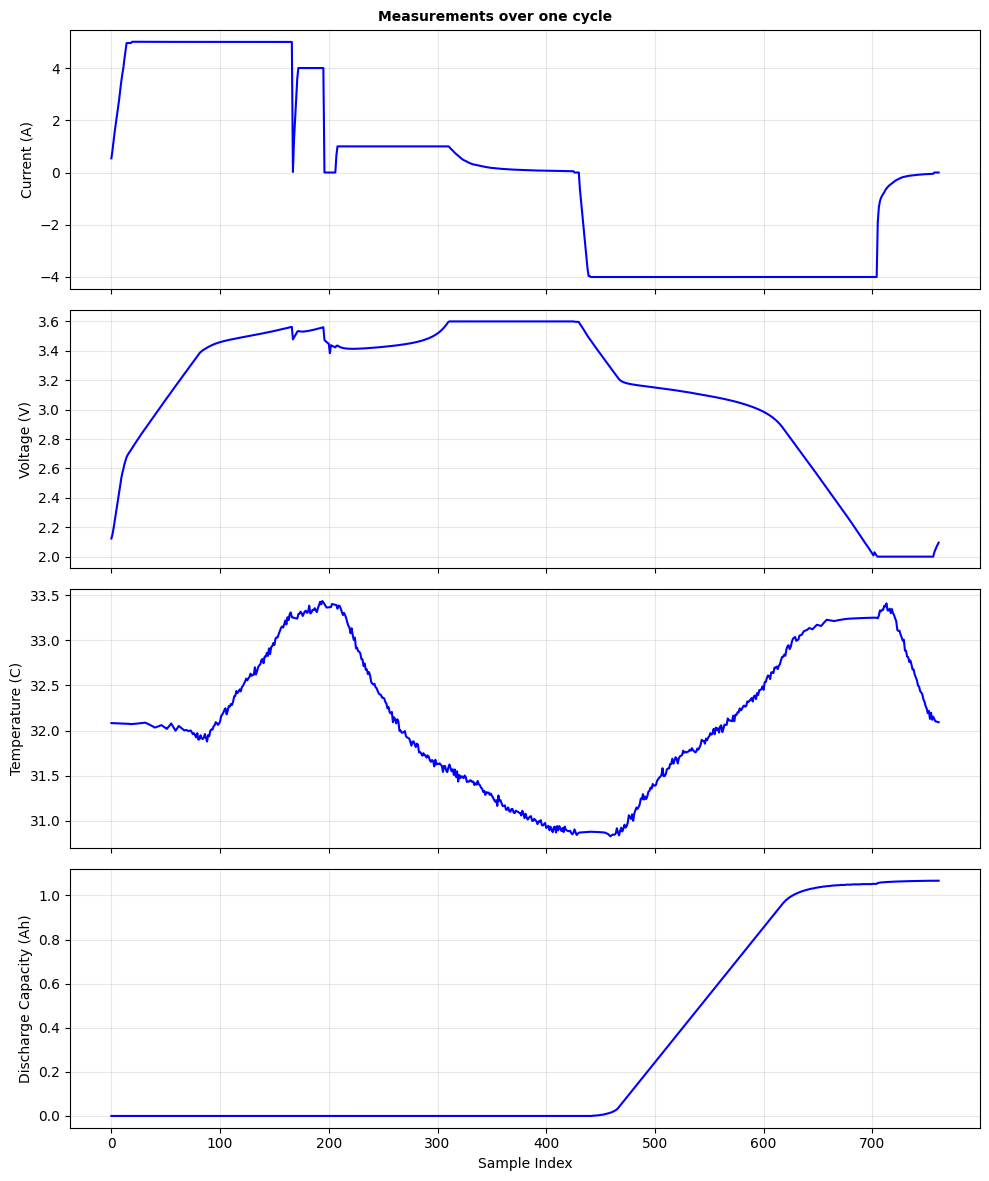

In [11]:
battery_measurements = df[
    (df['BatteryIndex'] == 0) & 
    (df['CycleIndex'] == 0)
].copy()

# stacked plot
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
fig.suptitle('Measurements over one cycle', fontsize=10, fontweight='bold')

# plot each measurement
battery_measurements['I'].plot(ax=axes[0], color='b', linewidth=1.5)
axes[0].set_ylabel('Current (A)')
axes[0].grid(True, alpha=0.3)

battery_measurements['V'].plot(ax=axes[1], color='b', linewidth=1.5)
axes[1].set_ylabel('Voltage (V)')
axes[1].grid(True, alpha=0.3)

battery_measurements['T'].plot(ax=axes[2], color='b', linewidth=1.5)
axes[2].set_ylabel('Temperature (C)')
axes[2].grid(True, alpha=0.3)

battery_measurements['Qd'].plot(ax=axes[3], color='b', linewidth=1.5)
axes[3].set_ylabel('Discharge Capacity (Ah)')
axes[3].set_xlabel('Sample Index')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Extract Battery Discharge Measurements

In the plot above, positive current indicates a charging process while negative current indicates a discharge operation. The battery is fully charged when it reaches 3.6V and fully discharged when it reaches 2V. Further, the batteries are subjected to different fast charging policies in this data set to understand their degradation profile across time and load.

Since all batteries have different charging policies but identical discharge voltage range, you use only the discharge portions of the signals in this example. 
Extract the measurements corresponding to the discharge portion of the cycle using the hExtractDischargeData helper function. Plot the discharge data for the first cycle of the first battery.

In [12]:
# We know discharge is when there is a negative current
discharge_data = df[df['I'] < 0].copy()
discharge_battery_measurements = discharge_data[
    (discharge_data['BatteryIndex'] == 0) & 
    (discharge_data['CycleIndex'] == 0)
].copy()

In [13]:
discharge_battery_measurements.head()

,BatteryIndex,CycleIndex,I,V,T,Qd
431,0,0,-0.639688,3.582515,30.872307,0.000006
432,0,0,-1.080069,3.572184,30.873091,0.000006
433,0,0,-1.520453,3.561411,30.873842,0.000047
434,0,0,-1.960487,3.549908,30.874582,0.000047
435,0,0,-2.360555,3.539153,30.875329,0.000047


In [14]:
discharge_battery_measurements['V'].max()

3.5825152

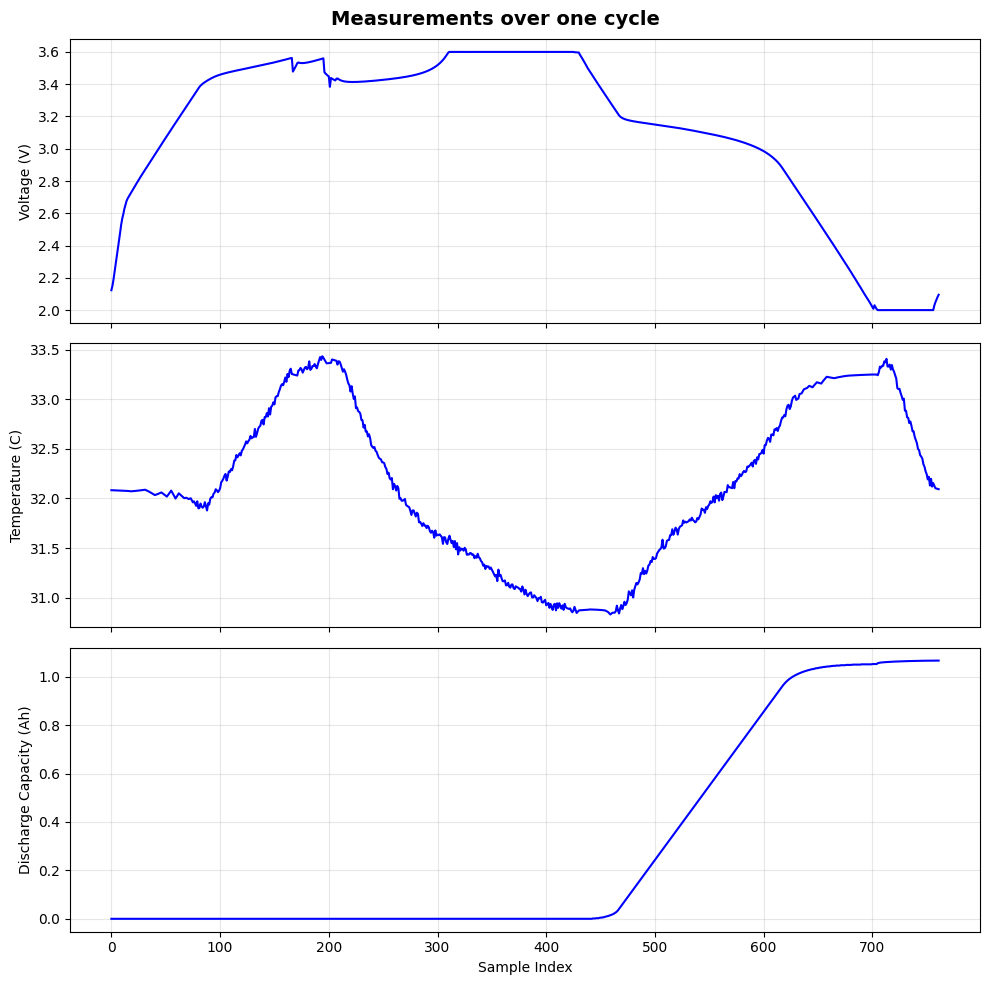

In [15]:

# stacked plot
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
fig.suptitle('Measurements over one cycle', fontsize=14, fontweight='bold')

# Voltage
battery_measurements['V'].plot(ax=axes[0], color='b', linewidth=1.5)
axes[0].set_ylabel('Voltage (V)')
axes[0].grid(True, alpha=0.3)

# Temperature
battery_measurements['T'].plot(ax=axes[1], color='b', linewidth=1.5)
axes[1].set_ylabel('Temperature (C)')
axes[1].grid(True, alpha=0.3)

# Discharge Capacity
battery_measurements['Qd'].plot(ax=axes[2], color='b', linewidth=1.5)
axes[2].set_ylabel('Discharge Capacity (Ah)')
axes[2].set_xlabel('Sample Index')
axes[2].grid(True, alpha=0.3)

# Adjust layout and show
plt.tight_layout()
plt.show()

Since the batteries in this data set are tested with different charging policies, some cycles are completed sooner than others. Therefore, cycle time cannot be used to compare charge and temperature across batteries. The voltage range is used as the reference instead of time because the discharge time varies based on the connected load and the health of the batteries. The charge and temperature measurements are then interpolated over this voltage range.

Use hLinearInterpolation function to interpolate voltage, temperature and discharge capacity measurements onto a uniformly sampled 900 point voltage range between 3.6V and 2V. The interpolated data is returned as a 30x30 array for each measurement to form a 2-D representation for each battery discharge cycle. Note that reshaping the 900x1 vector to a 30x30 matrix leads to the convolutional network searching for spatial relation between each column of the matrix. This example assumes that such a relationship might exist across the various cycles and attempts to leverage it if present. The image below shows the temperature and voltage data for a single cycle of a cell being interpolated to 900 points and then being reshaped to a 30x30. The 2-D representation the measurement of each cycle converts the sensor measurements into an image format for the CNN layers.

In [16]:
def linearInterpolation(discharge_battery_measurements):
    # returning a 30x30 array for each measurement to form a 2-D representation for each battery discharge cycle.
    
    voltage_range = np.linspace(3.6, 2.0, 900)

    # output dicts
    V_interpol = {}
    T_interpol = {}
    Qd_interpol = {}

    # only keep unique pairings of battery cycles, and get those rows
    battery_cycles = discharge_battery_measurements[['BatteryIndex', 'CycleIndex']].drop_duplicates()
    for _, row in battery_cycles.iterrows():
        battery_index = row['BatteryIndex']
        cycle_index = row['CycleIndex']
        
        cycle_data = discharge_battery_measurements[
        (discharge_battery_measurements['BatteryIndex'] == battery_index) & 
        (discharge_battery_measurements['CycleIndex'] == cycle_index)
        ].copy()

        # Sort by voltage (numpy inter needs it sorted)
        cycle_data = cycle_data.sort_values('V', ascending=False)

        # Now we will create interpolation functions

        # Remove duplicate voltage values
        unique_indices = ~cycle_data['V'].duplicated()
        voltage_unique = cycle_data['V'][unique_indices].values
        temp_unique = cycle_data['T'][unique_indices].values
        qd_unique = cycle_data['Qd'][unique_indices].values

        # sort because numpy.interp requires x in ascending order
        if voltage_unique[0] > voltage_unique[-1]:  
            voltage_sorted = voltage_unique[::-1]
            temp_sorted = temp_unique[::-1]
            qd_sorted = qd_unique[::-1]
        else:
            voltage_sorted = voltage_unique
            temp_sorted = temp_unique  
            qd_sorted = qd_unique
            
        voltage_range_sorted = voltage_range[::-1]  # make ascending

        v_interp = np.interp(voltage_range_sorted, voltage_sorted, voltage_sorted)
        t_interp = np.interp(voltage_range_sorted, voltage_sorted, temp_sorted)
        qd_interp = np.interp(voltage_range_sorted, voltage_sorted, qd_sorted)
        
        # flip back to original order (3.6V to 2V)
        v_interp = v_interp[::-1]
        t_interp = t_interp[::-1]
        qd_interp = qd_interp[::-1]
        
        # Reshape to 30x30 arrays
        key = (battery_index, cycle_index)
        V_interpol[key] = v_interp.reshape(30, 30)
        T_interpol[key] = t_interp.reshape(30, 30)
        Qd_interpol[key] = qd_interp.reshape(30, 30)

    return V_interpol, T_interpol, Qd_interpol


In [17]:
V_interpol, T_interpol, Qd_interpol = linearInterpolation(discharge_battery_measurements)

print(f"Interpolated data for {len(V_interpol)} battery cycles")
print(f"Each measurement is a 30x30 array ({30*30} = 900 points)")

Interpolated data for 1 battery cycles
Each measurement is a 30x30 array (900 = 900 points)


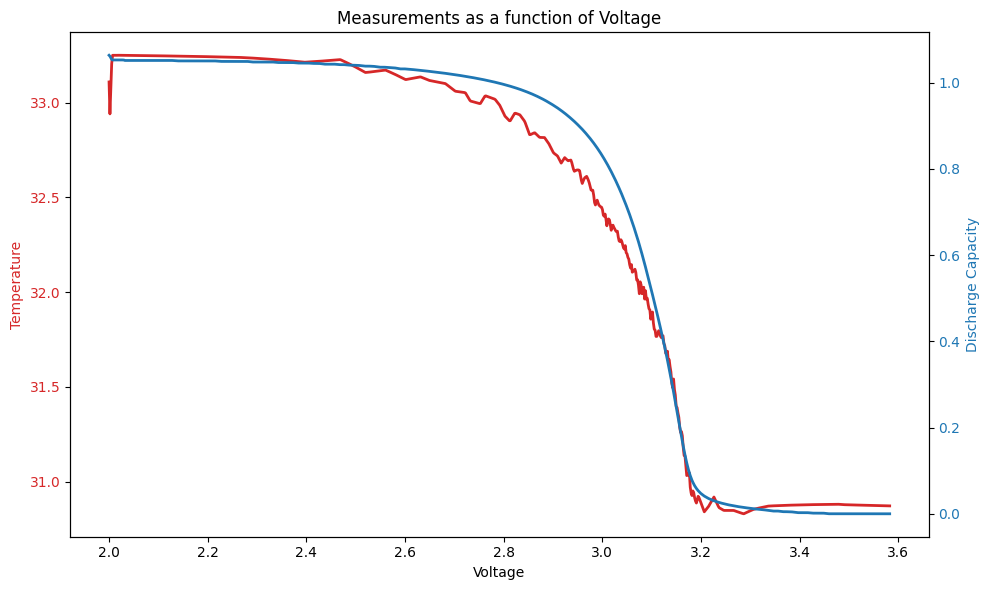

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your function returns V_interpol, T_interpol, Qd_interpol
# V_interpol, T_interpol, Qd_interpol = linearInterpolation(discharge_battery_measurements)

# Get the first battery (index 0) and first cycle (index 0)
# Adjust these indices based on what keys actually exist in your dictionaries
battery_idx = 0
cycle_idx = 0
key = (battery_idx, cycle_idx)

# Extract and reshape the data from 30x30 back to 900x1
voltage_data = V_interpol[key].reshape(900, 1).flatten()
temp_data = T_interpol[key].reshape(900, 1).flatten()
qd_data = Qd_interpol[key].reshape(900, 1).flatten()

# Create the plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left y-axis - Temperature vs Voltage
color1 = 'tab:red'
ax1.set_xlabel('Voltage')
ax1.set_ylabel('Temperature', color=color1)
ax1.plot(voltage_data, temp_data, color=color1, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color1)

# Right y-axis - Discharge Capacity vs Voltage
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Discharge Capacity', color=color2)
ax2.plot(voltage_data, qd_data, color=color2, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('Measurements as a function of Voltage')
fig.tight_layout()
plt.show()

For the 2-D Convolution Neural Network layers in the deep network, the 30x30 matrix of interpolated voltage, discharge capacity and temperature are reshaped to a form a 30x30x3 matrix for each cycle. This is like the RGB channels of an image. To minimize the range of the estimated remaining cycles, the expected output signal is normalized by dividing by 2000 (the maximum life of the battery in the data). The data from 30 batteries is used for training, 5 batteries for validation and 5 batteries for testing of the deep neural network. Use the hreshapeData helper function to create the 30x30x3 data set for each cycle. This function outputs the measurement data (trainData) and the RUL data (trainRulData) to use as labels for each case.

In [19]:
def hreshapeData(V_interpol, T_interpol, Qd_interpol):

    # Get all the keys (battery-cycle combinations) from the voltage dictionary
    all_keys = list(V_interpol.keys())
    num_samples = len(all_keys)
    print(f"Processing {num_samples} battery-cycle combinations...")

    # initializing arrays
    train_data = np.zeros((num_samples, 30, 30, 3))
    train_rul_data = np.zeros(num_samples)

    # go through each battery/cycle combination
    for i, key in enumerate(all_keys):
        battery_index, cycle_index = key
        
        # Extract the 30x30 matrices for this battery-cycle combination
        voltage_matrix = V_interpol[key]      # 30x30 voltage data
        temp_matrix = T_interpol[key]         # 30x30 temperature data
        qd_matrix = Qd_interpol[key]          # 30x30 discharge capacity data
        
        # this is like the 3 channeled RGB
        train_data[i, :, :, 0] = voltage_matrix
        train_data[i, :, :, 1] = temp_matrix
        train_data[i, :, :, 2] = qd_matrix

        # RUL would be total cycles for this battery - the current cycle
        # find all cycles and then the max
        battery_cycles = [c for (b, c) in all_keys if b == battery_idx]
        max_cycle_for_battery = max(battery_cycles)

        rul = max_cycle_for_battery - cycle_idx
        train_rul_data[i] = rul / 2000.0  # Normalize by maximum expected life
        
        # Print progress every 100 samples
        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{num_samples} samples...")

    print(f"Final data shape: {train_data.shape}")
    print(f"RUL data shape: {train_rul_data.shape}")
    
    return train_data, train_rul_data

In [20]:
def prepare_battery_data_for_cnn(V_interpol, T_interpol, Qd_interpol, total_batteries=40):
    # returns Tuple of (train_data, train_rul_data, val_data, val_rul_data, test_data, test_rul_data)

    # Get battery indicies fro train, validation and test split (copying the indicies it from mathworks)
    test_battery_indices = list(range(2, total_batteries + 1, 8))
    test_battery_indices = [idx - 1 for idx in test_battery_indices] # convert so its 0 indexed
     
    val_battery_indices = list(range(1, total_batteries + 1, 8))
    val_battery_indices = [idx - 1 for idx in val_battery_indices]  # convert so its 0 indexed
    
    # All batteries except test and validation batteries
    all_battery_indices = list(range(total_batteries))
    excluded_indices = set(test_battery_indices + val_battery_indices)
    train_battery_indices = [idx for idx in all_battery_indices if idx not in excluded_indices]
    
    print(f"Train batteries (count: {len(train_battery_indices)}): {train_battery_indices}")
    print(f"Validation batteries (count: {len(val_battery_indices)}): {val_battery_indices}")  
    print(f"Test batteries (count: {len(test_battery_indices)}): {test_battery_indices}")
    
    # Filter dictionaries for each dataset split
    def filter_dict_by_battery_indices(data_dict, battery_indices):
        """Filter dictionary to only include specified battery indices"""
        filtered_dict = {}
        for (batt_idx, cycle_idx), data in data_dict.items():
            if batt_idx in battery_indices:
                filtered_dict[(batt_idx, cycle_idx)] = data
        return filtered_dict
    
    # Create filtered dictionaries for training data
    print("\nFiltering training data...")
    train_V = filter_dict_by_battery_indices(V_interpol, train_battery_indices)
    train_T = filter_dict_by_battery_indices(T_interpol, train_battery_indices)
    train_Qd = filter_dict_by_battery_indices(Qd_interpol, train_battery_indices)
    
    # Create filtered dictionaries for validation data
    print("Filtering validation data...")
    val_V = filter_dict_by_battery_indices(V_interpol, val_battery_indices)
    val_T = filter_dict_by_battery_indices(T_interpol, val_battery_indices)
    val_Qd = filter_dict_by_battery_indices(Qd_interpol, val_battery_indices)
    
    # Create filtered dictionaries for test data
    print("Filtering test data...")
    test_V = filter_dict_by_battery_indices(V_interpol, test_battery_indices)
    test_T = filter_dict_by_battery_indices(T_interpol, test_battery_indices)
    test_Qd = filter_dict_by_battery_indices(Qd_interpol, test_battery_indices)
    
    # Reshape data for each split using the helper function
    print("\n" + "="*50)
    print("RESHAPING TRAINING DATA")
    print("="*50)
    train_data, train_rul_data = hreshapeData(train_V, train_T, train_Qd)
    
    print("\n" + "="*50)
    print("RESHAPING VALIDATION DATA") 
    print("="*50)
    val_data, val_rul_data = hreshapeData(val_V, val_T, val_Qd)
    
    print("\n" + "="*50)
    print("RESHAPING TEST DATA")
    print("="*50)
    test_data, test_rul_data = hreshapeData(test_V, test_T, test_Qd)
    
    # Print final statistics
    print("\n" + "="*60)
    print("FINAL DATA SUMMARY")
    print("="*60)
    print(f"Training data shape: {train_data.shape}")
    print(f"Training RUL data shape: {train_rul_data.shape}")
    print(f"Validation data shape: {val_data.shape}")
    print(f"Validation RUL data shape: {val_rul_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    print(f"Test RUL data shape: {test_rul_data.shape}")
    
    # Equivalent to MATLAB's fprintf statement
    print(f"\nSize of reshaped matrix of interpolated measurement data: {train_data.shape[0]}x{train_data.shape[1]}x{train_data.shape[2]}x{train_data.shape[3]}")
    
    return train_data, train_rul_data, val_data, val_rul_data, test_data, test_rul_data


In [21]:
train_data, train_rul_data, val_data, val_rul_data, test_data, test_rul_data = prepare_battery_data_for_cnn(
    V_interpol, T_interpol, Qd_interpol, total_batteries=40
)

Train batteries (count: 30): [2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39]
Validation batteries (count: 5): [0, 8, 16, 24, 32]
Test batteries (count: 5): [1, 9, 17, 25, 33]

Filtering training data...
Filtering validation data...
Filtering test data...

RESHAPING TRAINING DATA
Processing 0 battery-cycle combinations...
Final data shape: (0, 30, 30, 3)
RUL data shape: (0,)

RESHAPING VALIDATION DATA
Processing 1 battery-cycle combinations...
Final data shape: (1, 30, 30, 3)
RUL data shape: (1,)

RESHAPING TEST DATA
Processing 0 battery-cycle combinations...
Final data shape: (0, 30, 30, 3)
RUL data shape: (0,)

FINAL DATA SUMMARY
Training data shape: (0, 30, 30, 3)
Training RUL data shape: (0,)
Validation data shape: (1, 30, 30, 3)
Validation RUL data shape: (1,)
Test data shape: (0, 30, 30, 3)
Test RUL data shape: (0,)

Size of reshaped matrix of interpolated measurement data: 0x30x30x3
